<a href="https://colab.research.google.com/github/nikadilli/elemental-imaging-enhancement/blob/master/UNetSR_test_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Elemental Imaging Enhancement

**Elemental imaging** is visualization of the distribution of elements of interest within solid samples. It is widely used across different fields analyzing various materials by many analytical techniques. With destructive methods, such as LA-ICP-MS or LIBS, where the sample is ablated by laser beam spot by spot, we get pixelated image where the resolution is dependant on the beam size. Decreasing the beam size infinitely is not possible, which leads us to image enhancement by computers.

This notebook can be used to test a model trained on cell images that were virtualy ablated.

# Notebook setup

Clone github repository for elemental imaging.

In [0]:
!git clone https://github.com/nikadilli/elemental-imaging-enhancement 

Cloning into 'elemental-imaging-enhancement'...
remote: Enumerating objects: 190, done.
remote: Counting objects: 100% (190/190), done.
remote: Compressing objects: 100% (147/147), done.
remote: Total 190 (delta 75), reused 129 (delta 34), pack-reused 0
Receiving objects: 100% (190/190), 10.56 MiB | 14.87 MiB/s, done.
Resolving deltas: 100% (75/75), done.


In [0]:
# change working directory 
cd ./elemental-imaging-enhancement

/content/elemental-imaging-enhancement


In [0]:
# check content of working directory
!ls

data_processing.ipynb  README.md		UnetSR_test.ipynb
LICENSE		       results			UNetSR_train.ipynb
misc.py		       test_data		VGGFeatureLoss.py
pretty_plot.ipynb      UNetSR_test_colab.ipynb	vizualize.py


Import libraries.

In [0]:
import fastai
from fastai.vision import *
from fastai.callbacks import *
from fastai.utils.mem import *
import requests
from torchvision.models import vgg16_bn
from misc import prediction_to_image

## Parameters

variable|description
---|---
width|desired width of image
height|desired height of image
path|path to folder containing dataset
LR_folder| name of folder with low res images
HR_folder| name of folder with high res images

The model was trained and tested to increase the resolution 3 times, using higher enhancement can lead to artefacts. The original images of cells are 512x512, they were ablated using beam size of 5μm resulting in LR images of size 103x103. Width and height is preset for 300x300 and paths to data are coresponding with GitHub repository. If you wish to use different dataset, change paths accordingly.
 

In [0]:
width = 300 #@param {type:"number"}
height = 300 #@param {type:"number"}
path = "./test_data" #@param {type:"string"}
LR_folder = "cellsLR" #@param {type:"string"}
HR_folder = "cellsHR" #@param {type:"string"}


In [0]:
size = (width, height)
path = Path(path)

Download pretrained weights from this [link](https://www.dropbox.com/s/aa7fqv4sypb0ecy/model.pth) into  folder called "models" or use the next cell to create the folder and download the weights.


In [0]:
!mkdir models
!wget https://www.dropbox.com/s/aa7fqv4sypb0ecy/model.pth -O models/m1.pth

--2019-11-21 09:09:54--  https://www.dropbox.com/s/aa7fqv4sypb0ecy/model.pth
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.1, 2620:100:6021:1::a27d:4101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/aa7fqv4sypb0ecy/model.pth [following]
--2019-11-21 09:09:54--  https://www.dropbox.com/s/raw/aa7fqv4sypb0ecy/model.pth
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uce38a79ff639d3a9b63f04db090.dl.dropboxusercontent.com/cd/0/inline/Aswib3S_vNx-odHHDcIHxjWFk0B9H369OM9p-3EC7sns68QC5h3GzIHVXLh9oXK2Y7TS3Mie-TAVdNxX-sa0io0uwBNX1qn5qYYODekjVCIJY4qXakhwNcuWGeU-rXHJBlw/file# [following]
--2019-11-21 09:09:55--  https://uce38a79ff639d3a9b63f04db090.dl.dropboxusercontent.com/cd/0/inline/Aswib3S_vNx-odHHDcIHxjWFk0B9H369OM9p-3EC7sns68QC5h3GzIHVXLh9oXK2Y7TS3Mie-TAVdNxX-sa0io0uwBNX1qn5qYYODekjVCIJY4qXakhwNcuW

# Data preparation

Create data bunch from folders. All images are transformed and normalized using imagenet stats, sice the model was created from pretrained weights of ResNet34 on Imagenet data. The number of channels is set to 3, when using grayscale image, it is copied 3 times to create 3 channel image. This is necessary due to the pretrained model having 3 channel input.

In [0]:
# create dataset from folder
data = (ImageImageList.from_folder(path/LR_folder).split_none()
          .label_from_func(lambda x: path/HR_folder/x.name)
          .transform(get_transforms(), size=size, tfm_y=True)
          .databunch(bs=1).normalize(imagenet_stats, do_y=True))
data.c = 3

In [0]:
# show data 
data

ImageDataBunch;

Train: LabelList (6 items)
x: ImageImageList
Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300)
y: ImageList
Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300)
Path: test_data/cellsLR;

Valid: LabelList (0 items)
x: ImageImageList

y: ImageList

Path: test_data/cellsLR;

Test: None

Create model architecture from ResNet34, which is the encoder of the unet model that was used for enhancement. All data is connected using fastai unet_learner, which is set to the evaluation mode. 

In [0]:
arch = models.resnet34
learn = unet_learner(data, arch, loss_func=F.l1_loss, blur=True, norm_type=NormType.Weight)
learn.path = Path('./')
learn.load('m1');
learn.model.eval()
learn.data = data

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 66.8MB/s]


Read image from file.

In [0]:
# get file name for LR and HR image
fn_lr = data.train_ds.x.items[2]; fn_lr
fn_hr = data.train_ds.y.items[2]; fn_hr

PosixPath('test_data/cellsHR/B02_s1_w5.png')

In [0]:
# load LR image 
img_lr = open_image(fn_lr)
img_lr.shape

torch.Size([3, 103, 103])

In [0]:
# load HR image 
img_hr = open_image(fn_hr)
img_hr.shape

torch.Size([3, 512, 512])

# Prediction test data

In [0]:
# enhance LR image 
p,img_pr,b = learn.predict(img_lr)

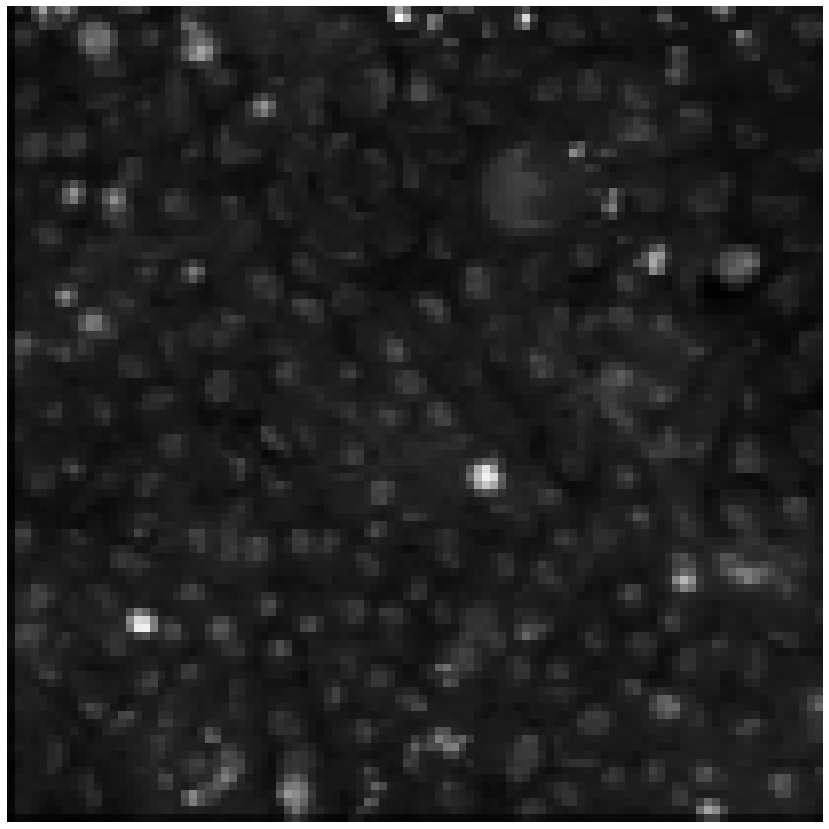

In [0]:
# show LR image
show_image(img_lr, figsize=(15,15), interpolation='nearest');

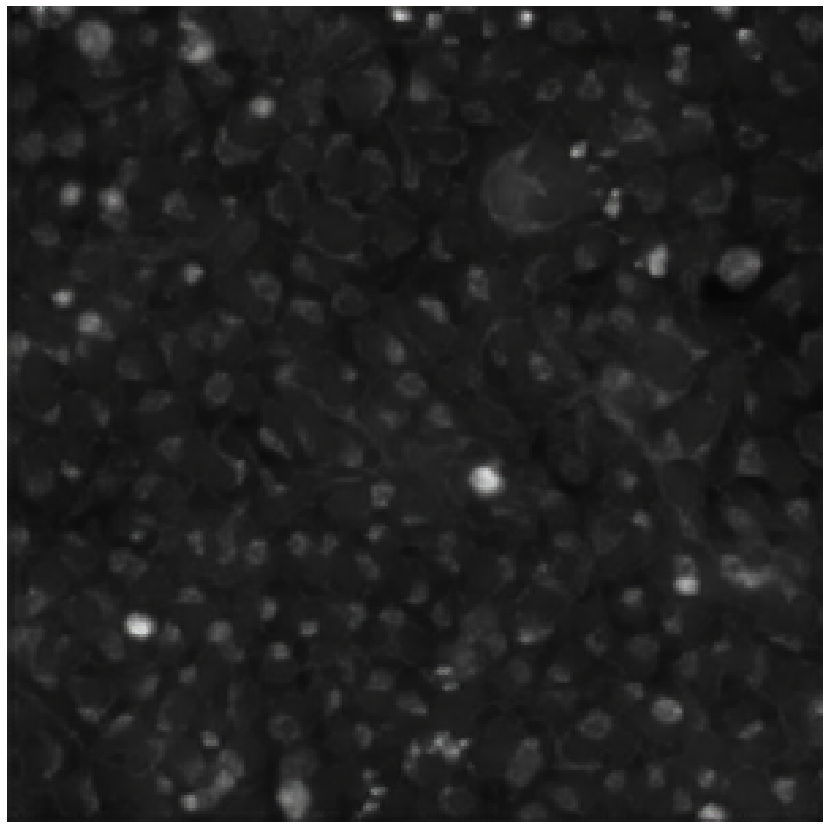

In [0]:
# Show enhanced image
Image(img_pr).show(figsize=(15,15))

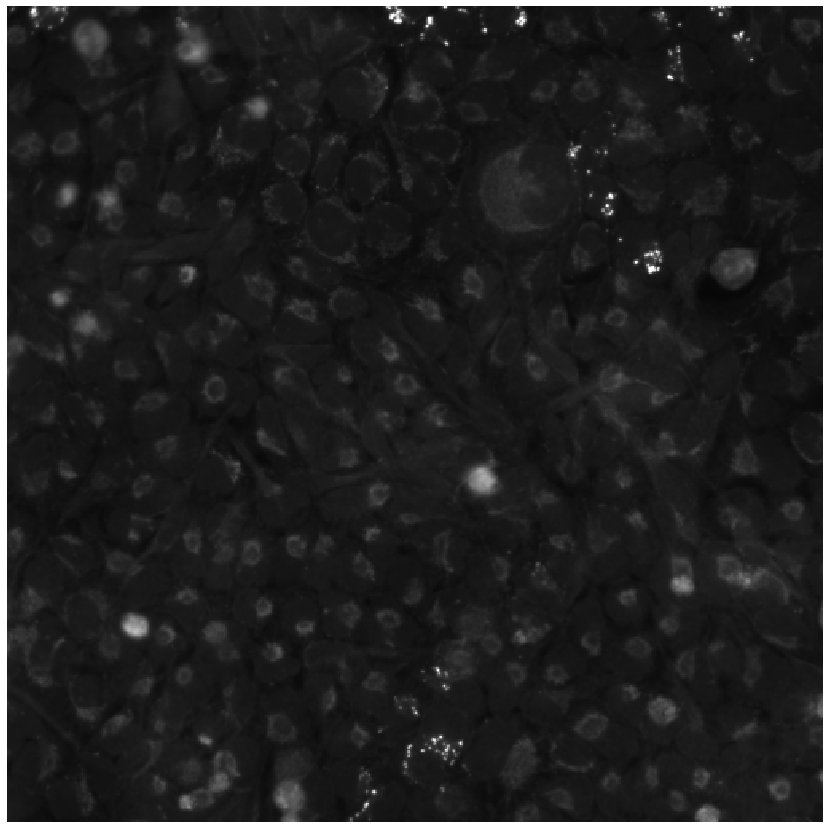

In [0]:
# Show HR image (Original before ablation)
show_image(img_hr, figsize=(15,15), interpolation='nearest');

# Prediction on own images

There exists many ways how to upload local image into this notebook. The simplest being direct upload from Google drive.

## Using Google drive
This requires uploading the image into this notebook. One way to do this, is to upload the image into your google drive and mount the drive. This will allow accesing files on your drive from this notebook by code. If you don't want to mount the drive for any reason, you can upload image into the temporary variables of this machine and use the path to that image. Simply click on the upload button on the left side under Files tab. 

In [0]:
# Skip this cell if you 
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# right click on the image in the file tree 
# and copy the path
img_path = "/content/drive/My Drive/LA data/E07_s2_w2_LR.png" #@param {type:"string"}



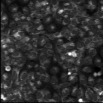

In [0]:
# load image and show it
img = open_image(img_path)
img

In [0]:
# enhance image 
p,img_pr,b = learn.predict(img)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


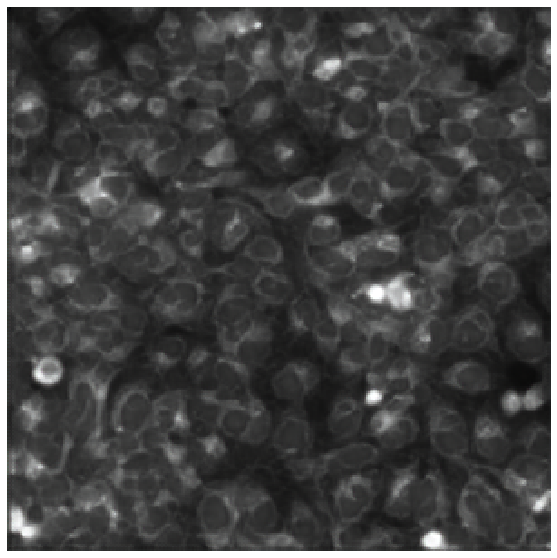

In [0]:
# show predicted image
Image(img_pr).show(figsize=(10,10))

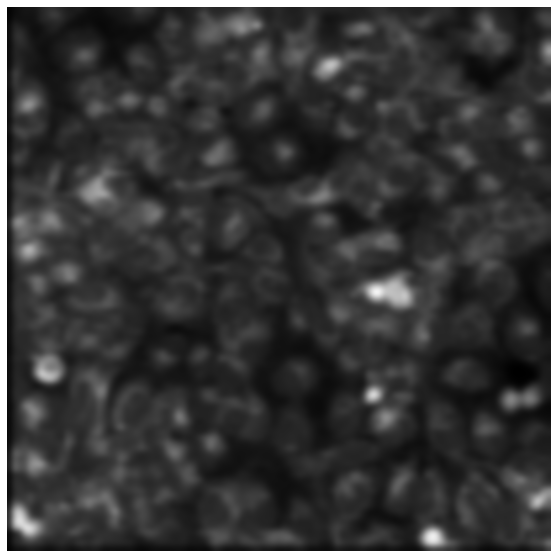

In [0]:
# show original image in defined size
show_image(img, figsize=(10,10), interpolation='bicubic');

## Saving image

You can easily save image by right click on the image and download image. 

Other way would be saving it back to your Google drive.

In [0]:
# Enter path to save image
save_path = "/content/drive/My Drive/LA data/output.png" #@param {type:"string"}

In [0]:
Image(img_pr).save(save_path)